# Reproducible Research - Assignment 10
Maciej Lorens

In [88]:
#!pip install numpy pandas statsmodels matplotlib

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.meta_analysis import combine_effects, effectsize_smd, effectsize_2proportions
import matplotlib.pyplot as plt

In [89]:
df = pd.read_excel('../data/metaanalysis_data.xlsx')
pd.set_option('display.max_columns', None)
df.head()

,Study,Female authors,Male authors,Age (months),N_boys,N_girls,Mean_boys_play_male,SD_boys_play_male,Mean_girls_play_male,SD_girls_play_male,Mean_boys_play_female,SD_boys_play_female,Mean_girls_play_female,SD_girls_play_female,Neutral toys,Year,Parent present,Setting,Country,Case definition adequate,Representativeness of cases,Selection of controls,Parental opinion,Comparability of both groups,Ascertainment of behaviour,Same ascertainment method for both groups,Non‐response rate,NOS score
0,Alexander & Saenz (2012),2,0,19.50,47,47,438.72,166.08,248.64,161.28,377.28,170.88,538.56,214.08,1,2012,3,2,0.256,*,*,X,X,*,*,*,X,5
1,Arthur (2014),1,0,19.00,22,18,148.00,105.00,54.00,53.00,126.00,67.00,244.00,54.00,0,2014,2,2,0.280,*,X,X,X,**,*,*,*,6
2,Berenbaum & Hines (1992),2,0,65.79,18,18,325.25,270.21,135.13,201.72,33.50,69.55,247.93,246.50,1,1992,2,2,0.252,X,*,*,*,*,*,*,X,6
3,Berenbaum & Snyder (1995),2,0,93.10,19,19,484.21,141.28,202.48,168.14,26.42,91.95,265.42,240.71,1,1995,2,1,0.252,*,X,*,*,*,*,*,*,7
4,Doering et al (1989),1,3,87.00,15,15,260.10,67.70,98.40,101.30,7.20,21.50,145.20,109.60,1,1989,1,2,0.141,*,*,*,X,*,*,*,X,6


Comparing playing time with toys maded for males among boys and girls.

In [90]:
# Calculate effect sizes and variances using proportions
df['effect_size'], df['variance'] = effectsize_smd(df['Mean_girls_play_male'], df['SD_girls_play_male'], df['N_girls'], 
                                                   df['Mean_boys_play_male'], df['SD_boys_play_male'], df['N_boys'])

In [91]:
# Conduct meta-analysis
effects = df['effect_size']
variances = df['variance']
result = combine_effects(effects, variances, use_t=False)  # Remove 'method' parameter

# Inspect the summary frame to identify the correct column names
summary_frame = result.summary_frame()
print(summary_frame)

# Extract the combined effect size
combined_effect = summary_frame['eff'].iloc[0]

                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                 -1.151674  0.223421 -1.589571 -0.713777  0.056433  0.043104
1                 -1.074697  0.342089 -1.745179 -0.404215  0.024072  0.035924
2                 -0.779640  0.347262 -1.460261 -0.099020  0.023360  0.035609
3                 -1.776137  0.389324 -2.539199 -1.013075  0.018585  0.033086
4                 -1.826148  0.444204 -2.696771 -0.955525  0.014276  0.029954
5                 -0.846942  0.471521 -1.771107  0.077222  0.012670  0.028479
6                 -0.230962  0.309740 -0.838041  0.376117  0.029362  0.037908
7                 -1.521240  0.262086 -2.034918 -1.007562  0.041011  0.040822
8                 -2.711052  0.591491 -3.870354 -1.551750  0.008052  0.022766
9                 -0.788885  0.294543 -1.366179 -0.211591  0.032470  0.038842
10                -2.075080  0.363590 -2.787704 -1.362456  0.021309  0.034620
11                -1.335650  0.309003 -1.941285 -0.730016  0.029

In [92]:
def funnel_plot(df, effect_col, variance_col, combined_effect=None):
    """
    Creates a funnel plot for meta-analysis.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data.
    effect_col (str): The name of the column containing effect sizes.
    variance_col (str): The name of the column containing variances.
    combined_effect (float): The combined effect size. If None, it will be calculated as a weighted average.

    Returns:
    None
    """
    # Calculate standard error from variance
    df['standard_error'] = np.sqrt(df[variance_col])

    # Calculate the combined effect size if not provided
    if combined_effect is None:
        weights = 1 / df[variance_col]
        combined_effect = np.sum(df[effect_col] * weights) / np.sum(weights)

    # Funnel plot
    plt.figure(figsize=(8, 6))
    plt.scatter(df[effect_col], df['standard_error'], alpha=0.5)

    # Add a vertical line at the combined effect size
    plt.axvline(combined_effect, color='r', linestyle='--')

    # Add pseudo confidence intervals (funnel shape)
    se_max = max(df['standard_error'])
    se_range = np.linspace(0, se_max, 100)
    lower_limit = combined_effect - 1.96 * se_range
    upper_limit = combined_effect + 1.96 * se_range
    plt.plot(lower_limit, se_range, linestyle='--', color='gray')
    plt.plot(upper_limit, se_range, linestyle='--', color='gray')

    # Labels and title
    plt.xlabel('Effect Size')
    plt.ylabel('Standard Error')
    plt.title('Funnel Plot')
    plt.gca().invert_yaxis()  # Invert y-axis to match the typical funnel plot appearance

    plt.show()

It would appear that a non reporting bias exists, based on the assymmetry displayed on the funnel plot.

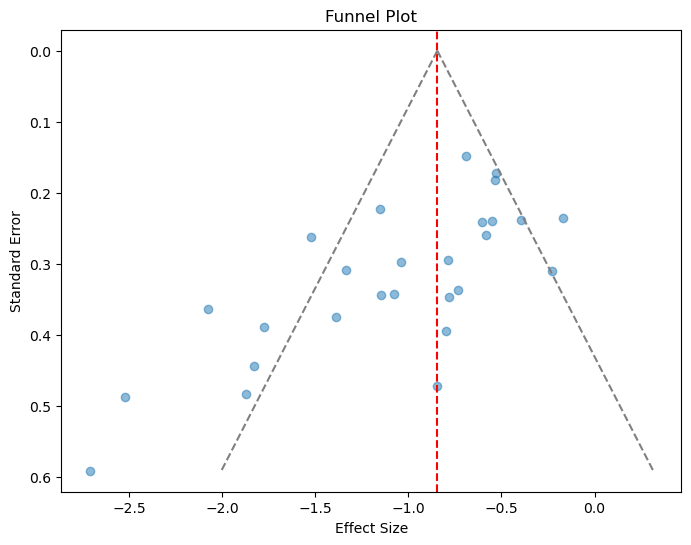

In [93]:
# Calculate standard error from variance
df['standard_error'] = np.sqrt(df['variance'])

funnel_plot(df, 'effect_size', 'variance')

In [94]:
def map_parents_presence(x):
    if x == 1:
        return 'absent'
    elif x == 2:
        return 'minimal interaction'
    else:
        return 'moderate or full interaction'

df['Parent present'] = df['Parent present'].map(map_parents_presence)

The effects, when split by the presence of parents, are quite far from the mean when the parents were completely absent.

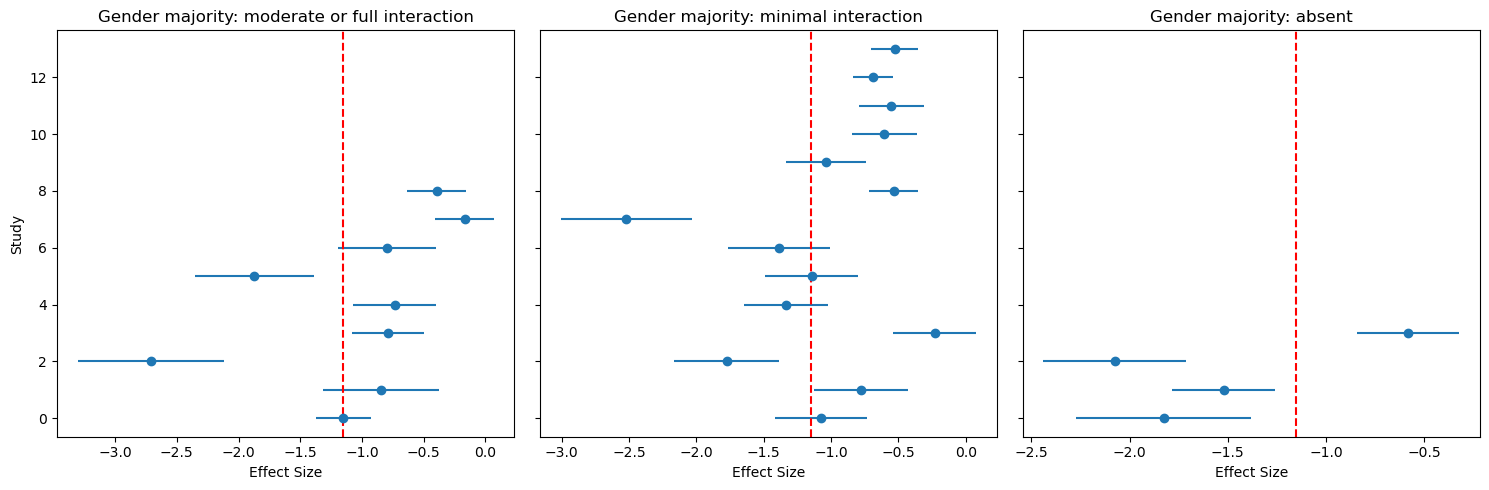

In [95]:
# Subgroup analysis by Parent present
parent_presence = df['Parent present'].unique()

# Create a figure for the horizontally stacked plots
fig, axs = plt.subplots(1, len(parent_presence), figsize=(15, 5), sharey=True)

for i, presence_type in enumerate(parent_presence):
    subgroup_data = df[df['Parent present'] == presence_type]
    effects = subgroup_data['effect_size']
    variances = subgroup_data['variance']
    result = combine_effects(effects, variances, use_t=False)
    # Plot the forest plot in the corresponding subplot
    axs[i].errorbar(effects, range(len(effects)), xerr=np.sqrt(variances), fmt='o')
    axs[i].axvline(combined_effect, color='r', linestyle='--')
    axs[i].set_title(f'Gender majority: {presence_type}')
    axs[i].set_xlabel('Effect Size')
    if i == 0:
        axs[i].set_ylabel('Study')
plt.tight_layout()
plt.show()

In [96]:
def get_author_majority(row):
    if row['Male authors'] > row['Female authors']:
        return 'male'
    elif row['Male authors'] < row['Female authors']:
        return 'female'
    else:
        return 'same'

df['author_majority'] = df.apply(get_author_majority, axis=1)

There are few studies where the majority of authors weren't female. In the studies where authors' genders were evenly split or majority male, the effects are not close to the mean effect.

/home/maciej/anaconda3/envs/mlenv/lib/python3.8/site-packages/statsmodels/stats/meta_analysis.py:620: RuntimeWarning: invalid value encountered in scalar divide
  scale_hksj_re = (weights_re * (eff - mean_effect_re)**2).sum() / df
/home/maciej/anaconda3/envs/mlenv/lib/python3.8/site-packages/statsmodels/stats/meta_analysis.py:621: RuntimeWarning: invalid value encountered in scalar divide
  scale_hksj_fe = (weights_fe * (eff - mean_effect_fe)**2).sum() / df
/home/maciej/anaconda3/envs/mlenv/lib/python3.8/site-packages/statsmodels/stats/meta_analysis.py:622: RuntimeWarning: invalid value encountered in scalar divide
  var_hksj_re = (weights_rel_re * (eff - mean_effect_re)**2).sum() / df
/home/maciej/anaconda3/envs/mlenv/lib/python3.8/site-packages/statsmodels/stats/meta_analysis.py:623: RuntimeWarning: invalid value encountered in scalar divide
  var_hksj_fe = (weights_rel_fe * (eff - mean_effect_fe)**2).sum() / df
/home/maciej/anaconda3/envs/mlenv/lib/python3.8/site-packages/statsmodel

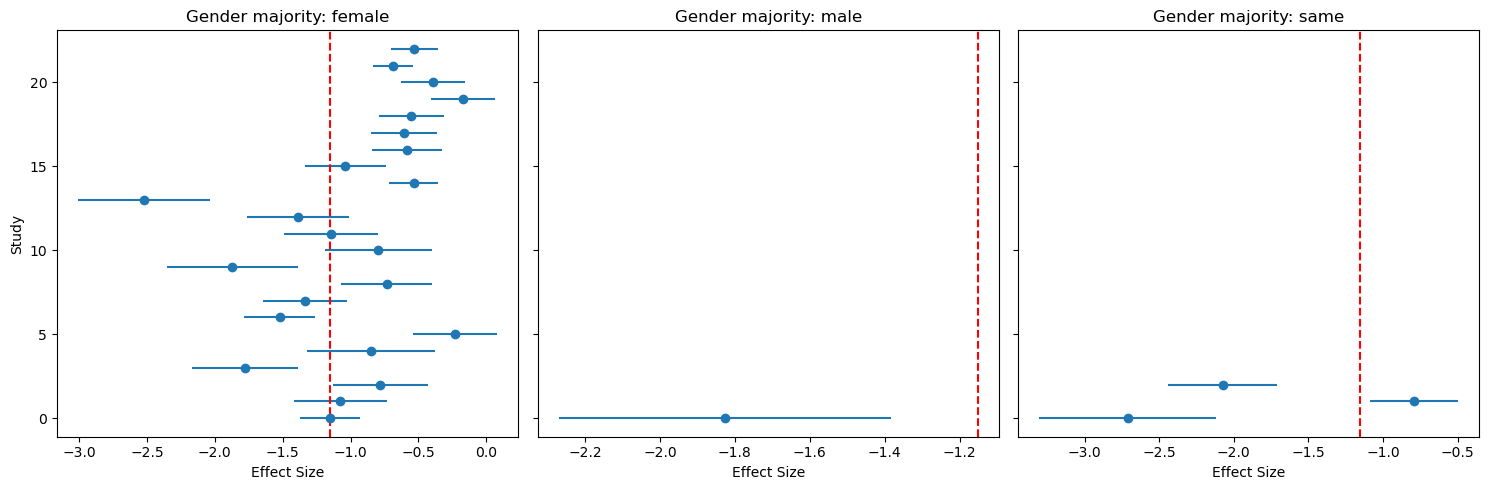

In [97]:
# Subgroup analysis by Parent present
genders = df['author_majority'].unique()

# Create a figure for the horizontally stacked plots
fig, axs = plt.subplots(1, len(parent_presence), figsize=(15, 5), sharey=True)

for i, gender in enumerate(genders):
    subgroup_data = df[df['author_majority'] == gender]
    effects = subgroup_data['effect_size']
    variances = subgroup_data['variance']
    result = combine_effects(effects, variances, use_t=False)
    # Plot the forest plot in the corresponding subplot
    axs[i].errorbar(effects, range(len(effects)), xerr=np.sqrt(variances), fmt='o')
    axs[i].axvline(combined_effect, color='r', linestyle='--')
    axs[i].set_title(f'Gender majority: {gender}')
    axs[i].set_xlabel('Effect Size')
    if i == 0:
        axs[i].set_ylabel('Study')
plt.tight_layout()
plt.show()